In [5]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define s3
bucket_name = 'nexttrendco'  
train_file_key = 'rossman/train.csv'  
val_file_key = 'rossman/val.csv'     
test_file_key = 'rossman/test.csv'   

# Load datasets from S3
train_rossman = pd.read_csv(f's3://{bucket_name}/{train_file_key}')
val_rossman = pd.read_csv(f's3://{bucket_name}/{val_file_key}')
test_rossman = pd.read_csv(f's3://{bucket_name}/{test_file_key}')

# Display first few rows of the data
print("Train Data:")
print(train_rossmann.head())
print("Validation Data:")
print(val_rossmann.head())
print("Test Data:")
print(test_rossmann.head())

/tmp/ipykernel_15426/3942308744.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_rossman = pd.read_csv(f's3://{bucket_name}/{train_file_key}')


Train Data:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
Validation Data:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0     46          2  2013-11-05   6339        726     1      1            0   
1    539          7  2015-04-05      0          0     0      0            0   
2   1059          4  2014-06-12   7202       1075     1      0            0   
3    825          7  2013-10-27      0          0     0      0    

In [17]:
# create lag and rolling mean features for train and validation
for df in [train_rossman, val_rossman]:
    df['lag_7'] = df['Sales'].shift(7) 
    df['rolling_7'] = df['Sales'].rolling(window=7).mean() 
    df['promo_lag_interaction'] = df['Promo'] * df['lag_7']  

# Drop NaN values
train_rossman.dropna(inplace=True)
val_rossman.dropna(inplace=True)

# Print  to verify the feature engineering
print("Train Data with Lag Features:")
print(train_rossman.head())

print("Validation Data with Lag Features:")
print(val_rossman.head())

Train Data with Lag Features:
    Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
21     22          5  2015-07-31   6566        633     1      1            0   
22     23          5  2015-07-31   7273        560     1      1            0   
23     24          5  2015-07-31  14190       1082     1      1            0   
24     25          5  2015-07-31  14180       1586     1      1            0   
25     26          5  2015-07-31   7818        611     1      1            0   

    SchoolHoliday    lag_7    rolling_7  promo_lag_interaction  
21              0   9191.0  8948.571429                 9191.0  
22              1  10231.0  8526.000000                10231.0  
23              1   8430.0  9348.857143                 8430.0  
24              1  10071.0  9935.857143                10071.0  
25              1   8234.0  9876.428571                 8234.0  
Validation Data with Lag Features:
    Store  DayOfWeek        Date  Sales  Customers  Open  Promo 

In [20]:
 # Convert 'StateHoliday' column to string type
train_rossman['StateHoliday'] = train_rossman['StateHoliday'].astype(str)
val_rossman['StateHoliday'] = val_rossman['StateHoliday'].astype(str)
test_rossman['StateHoliday'] = test_rossman['StateHoliday'].astype(str)

# Label encode the categorical feature 'StateHoliday'
le = LabelEncoder()
train_rossman['StateHoliday'] = le.fit_transform(train_rossman['StateHoliday'])
val_rossman['StateHoliday'] = le.transform(val_rossman['StateHoliday'])
test_rossman['StateHoliday'] = le.transform(test_rossman['StateHoliday'])

# Check data
print(train_rossman.head())

    Store  DayOfWeek        Date  Sales  Customers  Open  Promo  StateHoliday  \
21     22          5  2015-07-31   6566        633     1      1             0   
22     23          5  2015-07-31   7273        560     1      1             0   
23     24          5  2015-07-31  14190       1082     1      1             0   
24     25          5  2015-07-31  14180       1586     1      1             0   
25     26          5  2015-07-31   7818        611     1      1             0   

    SchoolHoliday    lag_7    rolling_7  promo_lag_interaction  
21              0   9191.0  8948.571429                 9191.0  
22              1  10231.0  8526.000000                10231.0  
23              1   8430.0  9348.857143                 8430.0  
24              1  10071.0  9935.857143                10071.0  
25              1   8234.0  9876.428571                 8234.0  


In [21]:
# Convert 'StateHoliday' column to numeric type
train_rossman['StateHoliday'] = pd.to_numeric(train_rossman['StateHoliday'], errors='coerce')
val_rossman['StateHoliday'] = pd.to_numeric(val_rossman['StateHoliday'], errors='coerce')
test_rossman['StateHoliday'] = pd.to_numeric(test_rossman['StateHoliday'], errors='coerce')

# Label encode categorical feature 'StateHoliday'
le = LabelEncoder()
train_rossman['StateHoliday'] = le.fit_transform(train_rossman['StateHoliday'].astype(str))
val_rossman['StateHoliday'] = le.transform(val_rossman['StateHoliday'].astype(str))
test_rossman['StateHoliday'] = le.transform(test_rossman['StateHoliday'].astype(str))

# Check data
print(train_rossman.head())

    Store  DayOfWeek        Date  Sales  Customers  Open  Promo  StateHoliday  \
21     22          5  2015-07-31   6566        633     1      1             0   
22     23          5  2015-07-31   7273        560     1      1             0   
23     24          5  2015-07-31  14190       1082     1      1             0   
24     25          5  2015-07-31  14180       1586     1      1             0   
25     26          5  2015-07-31   7818        611     1      1             0   

    SchoolHoliday    lag_7    rolling_7  promo_lag_interaction  
21              0   9191.0  8948.571429                 9191.0  
22              1  10231.0  8526.000000                10231.0  
23              1   8430.0  9348.857143                 8430.0  
24              1  10071.0  9935.857143                10071.0  
25              1   8234.0  9876.428571                 8234.0  


In [22]:
# Separate features and target variable
X_train_rossman = train_rossman.drop(columns=['Sales', 'Date'], errors='ignore')
y_train_rossman = train_rossman['Sales']

X_val_rossman = val_rossman.drop(columns=['Sales', 'Date'], errors='ignore')
y_val_rossman = val_rossman['Sales']

# Convert training and validation sets into DMatrix format
dtrain = xgb.DMatrix(X_train_rossman, label=y_train_rossman)
dval = xgb.DMatrix(X_val_rossman, label=y_val_rossman)

# Define watchlist to monitor performance during training
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [23]:
# Set parameters for model
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',  
    'eta': 0.1,  
    'max_depth': 6,  
    'subsample': 0.8,  
    'colsample_bytree': 0.8,  
    'alpha': 0,  
    'lambda': 1,  
    'silent': 1,  
    'n_jobs': -1  
}

In [24]:
# Train tmodel
model = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)

# Predict on validation data
y_val_pred = model.predict(dval)

# Evaluate model on validation data
mae = mean_absolute_error(y_val_rossman, y_val_pred)
rmse = mean_squared_error(y_val_rossman, y_val_pred, squared=False)

print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:48:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:3514.41159	eval-rmse:3566.26420
[1]	train-rmse:3216.07498	eval-rmse:3302.23260
[2]	train-rmse:2951.71263	eval-rmse:3069.57071
[3]	train-rmse:2719.28744	eval-rmse:2838.06867
[4]	train-rmse:2588.63198	eval-rmse:2710.42638
[5]	train-rmse:2397.22770	eval-rmse:2545.03298
[6]	train-rmse:2231.07519	eval-rmse:2380.38261
[7]	train-rmse:2146.21263	eval-rmse:2296.80861
[8]	train-rmse:2075.02538	eval-rmse:2226.32541
[9]	train-rmse:1948.65827	eval-rmse:2117.45141
[10]	train-rmse:1839.68265	eval-rmse:2024.14562
[11]	train-rmse:1779.35617	eval-rmse:1989.14817
[12]	train-rmse:1729.16958	eval-rmse:1961.06257
[13]	train-rmse:1648.74045	eval-rmse:1886.82270
[14]	train-rmse:1581.11588	eval-rmse:1816.63239
[15]	train-rmse:1522.91964	eval-rmse:1763.13707
[16]	train-rmse:1474.33600	eval-rmse:1710.88422
[17]	train-rmse:1435.15662	eval-rmse:1668.44910
[18]	train-rmse:1398.53334	eval-rmse:1634.55170
[19]	train-rmse:1369.50341	eval-rmse:1609.03945
[20]	train-rmse:1343.20301	eval-rmse:1585.88235
[2

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


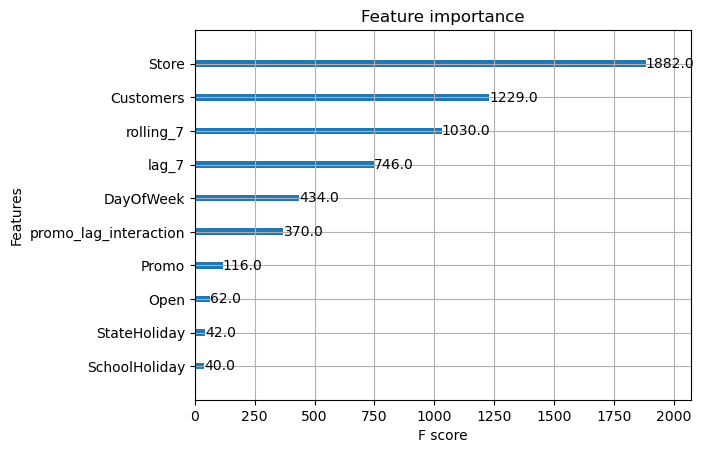

In [25]:
# Plot feature importance
import matplotlib.pyplot as plt

xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.show()

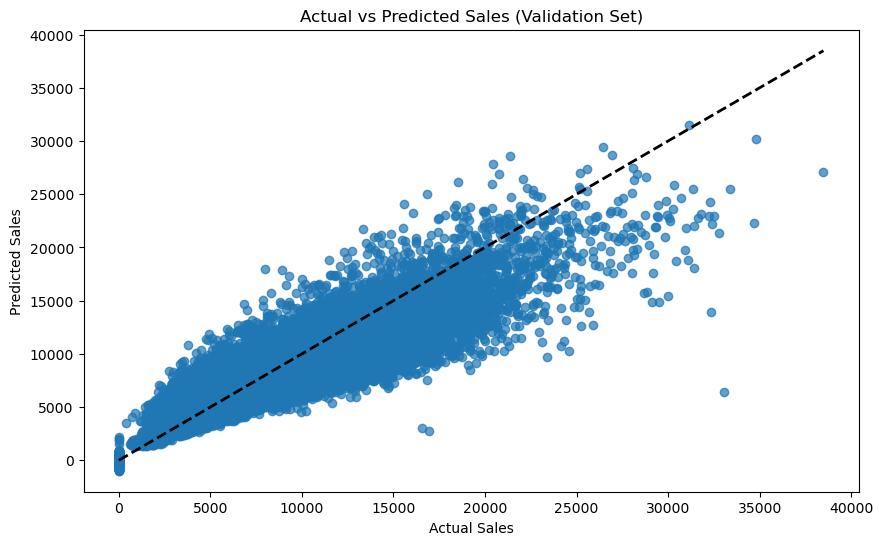

In [27]:
# Plot actual vs predicted values on the validation set
plt.figure(figsize=(10, 6))
plt.scatter(y_val_rossman, y_val_pred, alpha=0.7)
plt.plot([y_val_rossman.min(), y_val_rossman.max()], [y_val_rossman.min(), y_val_rossman.max()], 'k--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (Validation Set)')
plt.show()

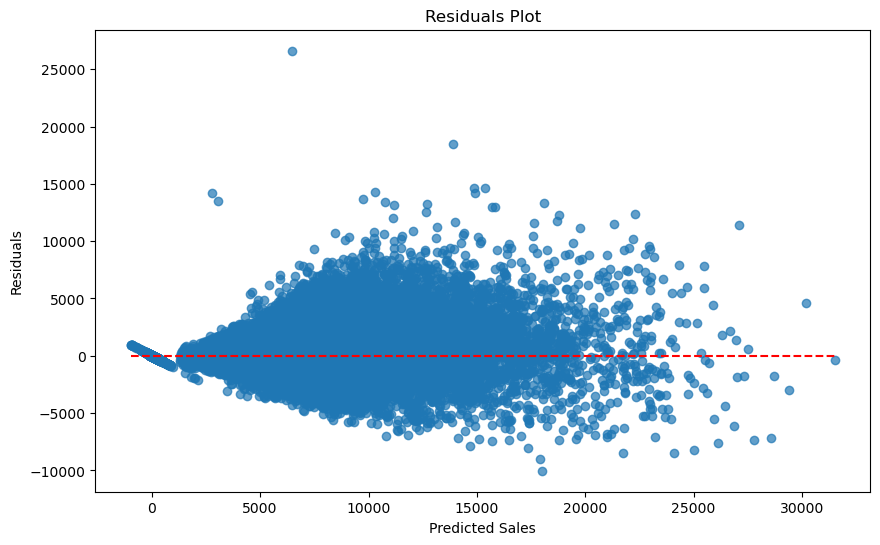

In [28]:
# Plot residuals
residuals = y_val_rossman - y_val_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.7)
plt.hlines(y=0, xmin=y_val_pred.min(), xmax=y_val_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()